In [1]:
!pip install keras

In [2]:
# Import the tools we will need from keras and sklearn
#import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string
import pandas as pd
import numpy as np
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

##Data exploration

In [3]:
# reading the file using pandas and pass arguments to tell the function that the delimiter is tab
# and there is no header in our data file
data = pd.read_csv('/content/drive/MyDrive/ANLP-Y4T3/imdb_labelled.tsv', header = None, delimiter='\t')

In [4]:
# setting the header
data.columns = ['Text', 'Label']
#check the header (output should show the specified column names in the previous cell)
data.head()

,Text,Label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [5]:
data.Label.unique() # returns an array or list of unique values present in the 'Label' column of the 'data' dataset

array([0, 1])

In [6]:
data.shape #check the shape of the data

(748, 2)

In [7]:
data.Label.value_counts()#Now we see the class distribution. We have 386 positive and 362 negative examples.

Label
1    386
0    362
Name: count, dtype: int64

##One-hot encoding

In [8]:
# adding positive (1) and negative (0) labels to each instance
pos = []
neg = []
for l in data.Label:
  if l == 0:
    pos.append(0)
    neg.append(1)
  elif l == 1:
    pos.append(1)
    neg.append(0)

data['Pos']= pos
data['Neg']= neg
data.head()

,Text,Label,Pos,Neg
0,"A very, very, very slow-moving, aimless movie ...",0,0,1
1,Not sure who was more lost - the flat characte...,0,0,1
2,Attempting artiness with black & white and cle...,0,0,1
3,Very little music or anything to speak of.,0,0,1
4,The best scene in the movie was when Gerardo i...,1,1,0


##Data cleaning

In [9]:
# removing non-alphabet characters or punctuations
def remove_punct(text):
  text_nopunct = ''
  text_nopunct = re.sub('['+string.punctuation+']', '', text)
  return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [10]:
# Tokenization
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean]

In [11]:
# turn tokens into lower-case
def lower_token(tokens):
  return [w.lower() for w in tokens]
lower_tokens = [lower_token(token) for token in tokens]

In [12]:
# getting stopwords in English
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [13]:
# removing stop words
def remove_stop_words(tokens):
  return [word for word in tokens if word not in stoplist]

In [14]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]
result = [' '.join(sen) for sen in filtered_words]
data['Text_Final'] = result
# adding the tokens to the dataset
data['tokens'] = filtered_words
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg']]
data[:4]

,Text_Final,tokens,Label,Pos,Neg
0,slowmoving aimless movie distressed drifting y...,"[slowmoving, aimless, movie, distressed, drift...",0,0,1
1,sure lost flat characters audience nearly half...,"[sure, lost, flat, characters, audience, nearl...",0,0,1
2,attempting artiness black white clever camera ...,"[attempting, artiness, black, white, clever, c...",0,0,1
3,little music anything speak,"[little, music, anything, speak]",0,0,1


##Split data into test and train

In [15]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

In [16]:
# Then we build training vocabulary and get maximum training sentence length and total number of words training data.
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words),
len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

7218 words total, with a vocabulary size of 2881
Max sentence length is 789


In [17]:
# Same thing is done for testing data.
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words),
len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

580 words total, with a vocabulary size of 457
Max sentence length is 24


##Load Google News Word2Vec model

In [18]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Embedding
from keras.layers import LSTM
from keras.models import Sequential
#from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Model

In [20]:
word2vec_path = "/content/drive/MyDrive/ANLP-Y4T3/GoogleNews-vectors-negative300.bin.gz" #downloaded W2V model
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [21]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
  if len(tokens_list)<1:
    return np.zeros(k)
  if generate_missing:
    vectorized = [vector[word] if word in vector else np.random.rand(k) for word  in tokens_list]
  else:
    vectorized = [vector[word] if word in vector else np.zeros(k) for word in  tokens_list]

  length = len(vectorized)
  summed = np.sum(vectorized, axis=0)
  averaged = np.divide(summed, length)
  return averaged

In [22]:
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
  embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x,  vectors, generate_missing=generate_missing))
  return list(embeddings)

##Get Embeddings

In [23]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [24]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

In [25]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 2881 unique tokens.


In [26]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [28]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
  train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(2882, 300)


In [29]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

##Define CNN

In [30]:
label_names = ['Pos', 'Neg'] # labels
y_train = data_train[label_names].values
y_test = data_test[label_names].values
print(y_train)

[[1 0]
 [0 1]
 [0 1]
 ...
 [1 0]
 [0 1]
 [0 1]]


In [31]:
labels_index = len(list(label_names))
print(labels_index)

2


In [32]:
num_words = len(train_word_index)+1
max_sequence_length = 50
embedding_dim = 300
embeddings =train_embedding_weights
embedding_layer = Embedding(num_words,embedding_dim,trainable=False)

In [33]:
embedding_layer.build((1,))
embedding_layer.set_weights([embeddings])

##Construct model

In [34]:
sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
conv_1 = Conv1D(filters=200, kernel_size=2, activation='relu')(embedded_sequences)
pool_1 = MaxPooling1D()(conv_1)
conv_2 = Conv1D(filters=200, kernel_size=3, activation='relu')(pool_1)
pool_2 = MaxPooling1D()(conv_2)
flattening = Flatten()(pool_2)
dp_1 = Dropout(0.1)(flattening)
dense_1 = Dense(128, activation='relu')(dp_1)
dp_2= Dropout(0.1)(dense_1)
out = Dense(labels_index, activation='sigmoid')(dp_2)

In [35]:
model = Model(inputs = sequence_input, outputs = out)

##Compile model

In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           864600    
                                                                 
 conv1d (Conv1D)             (None, 49, 200)           120200    
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 200)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 200)           120200    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 11, 200)           0         
 g1D)                                                        

In [37]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
early_stopping_monitor = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
# use this to apply a stopping criterion of 5 for the training epochs based on validation loss
#the training will stop if after 5 epochs there is no improvement in validation loss and will save best model in model_file

In [38]:
model_file = 'best_CNN_model.keras'

In [39]:
model_check_point = ModelCheckpoint(model_file, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [40]:
hist = model.fit(train_cnn_data, y_train, epochs=20, batch_size=32, verbose=1, validation_split=0.1, callbacks=[early_stopping_monitor, model_check_point])

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 0.6938 - acc: 0.5174
Epoch 1: val_loss improved from inf to 0.67436, saving model to best_CNN_model.keras
19/19 [==============================] - 4s 71ms/step - loss: 0.6938 - acc: 0.5174 - val_loss: 0.6744 - val_acc: 0.5735
Epoch 2/20
18/19 [===========================>..] - ETA: 0s - loss: 0.6473 - acc: 0.6944
Epoch 2: val_loss improved from 0.67436 to 0.63411, saving model to best_CNN_model.keras
19/19 [==============================] - 1s 55ms/step - loss: 0.6454 - acc: 0.6992 - val_loss: 0.6341 - val_acc: 0.6618
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.4974 - acc: 0.7983
Epoch 3: val_loss improved from 0.63411 to 0.55887, saving model to best_CNN_model.keras
19/19 [==============================] - 1s 56ms/step - loss: 0.4974 - acc: 0.7983 - val_loss: 0.5589 - val_acc: 0.7794
Epoch 4/20
19/19 [==============================] - ETA: 0s - loss: 0.3463 - acc: 0.8496
Epoch 4: val_loss did

##Load best model

In [41]:
from keras.models import load_model
model = load_model('best_CNN_model.keras')

In [42]:
# Test the model on the test data after training
test_results = model.evaluate(test_cnn_data, y_test, verbose=1)
print(f'Test results - Accuracy: {test_results[1]*100: .2f}%')

3/3 [==============================] - 0s 15ms/step - loss: 0.5053 - acc: 0.7867
Test results - Accuracy:  78.67%


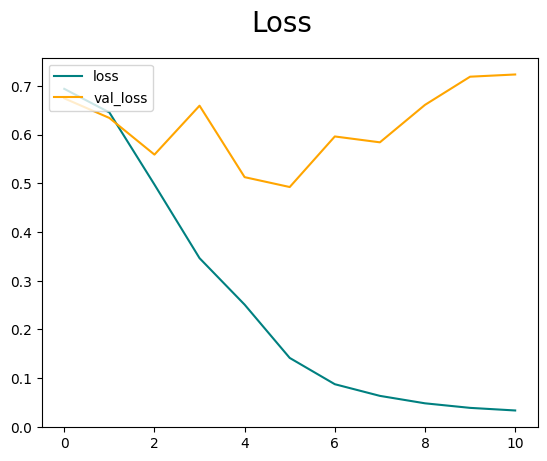

In [43]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()